In [5]:
!pip install opendatasets
!pip install pandas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
cd /content/

/content


In [7]:
import pandas
import tarfile
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from keras import applications
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.applications.vgg16 import preprocess_input, VGG16
from keras.optimizers import SGD
from keras.models import Sequential, Model
import numpy as np
import pandas as pd
import shutil
import os

In [8]:
import opendatasets as od
import pandas
  
od.download(
    "https://www.kaggle.com/datasets/saidakbarp/17-category-flowers",force = True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: heydan98
Your Kaggle Key: ··········


100%|██████████| 57.5M/57.5M [00:00<00:00, 125MB/s]


In [9]:
o = tarfile.open("17-category-flowers/17flowers.tgz")
o.extractall()

In [10]:
j = 0
total = 1361
for i  in range(1, total):
    fpath = f"jpg/image_{str(i).zfill(4)}.jpg"
    destPath = 'flower_dataset/'+str(j).zfill(2)
    if not os.path.exists(destPath):
        os.makedirs(destPath)
    shutil.copy(fpath, destPath)

    if i%80==0:
        j+=1

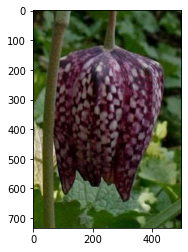

In [11]:
import matplotlib.pyplot as plt

img = load_img('flower_dataset/08/image_0641.jpg')
x = img_to_array(img)
g = plt.imshow(x/255.)

In [12]:
batch_size = 16

#Data Augmentation
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)


#Normalize
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
        'flower_dataset',  
        target_size=(224, 224),  
        batch_size=batch_size,
        class_mode='categorical',
        subset="training")  

validation_generator = train_datagen.flow_from_directory(
        'flower_dataset',  
        target_size=(224, 224),  
        batch_size=batch_size,
        class_mode='categorical',
        subset="validation") 

Found 1088 images belonging to 17 classes.
Found 272 images belonging to 17 classes.


In [13]:
def vgg16_model():
    vgg_conv = VGG16(weights= "imagenet" , include_top=False, 
                     input_shape=(224, 224, 3))
    vgg_conv.trainable = False
    model = Sequential()
    
    for layer in vgg_conv.layers:
        model.add(layer)

    # Add new layers
    model.add(Flatten())
    model.add(Dropout(0.3)) 
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(17, activation='softmax'))
    return model

model = vgg16_model()
model.summary()

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0         
                                                         

In [14]:
import keras
batch_size = 34
ntrain = 1100
nval = 260

# choosing Adam optimizer, also defining loss function and evaluation metrics
model.compile(
    optimizer=keras.optimizers.Adam(epsilon=0.00001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# fitting the model over 100 epochs here
# cutoff criteria can be set for no of epochs 
# if the accuracy doesn't increase appreciable over iterations
history = model.fit_generator(
    train_generator,
    validation_data=validation_generator,
    epochs=80,
    steps_per_epoch = ntrain // batch_size,
    validation_steps = nval // batch_size
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/80
32/32 [==============================] - 24s 371ms/step - loss: 2.9218 - accuracy: 0.1895 - val_loss: 2.0525 - val_accuracy: 0.4018
Epoch 2/80
32/32 [==============================] - 10s 314ms/step - loss: 2.0486 - accuracy: 0.3516 - val_loss: 1.3688 - val_accuracy: 0.6071
Epoch 3/80
32/32 [==============================] - 10s 314ms/step - loss: 1.6920 - accuracy: 0.4395 - val_loss: 1.1399 - val_accuracy: 0.6607
Epoch 4/80
32/32 [==============================] - 11s 347ms/step - loss: 1.4486 - accuracy: 0.5371 - val_loss: 0.8872 - val_accuracy: 0.7589
Epoch 5/80
32/32 [==============================] - 11s 333ms/step - loss: 1.1953 - accuracy: 0.6230 - val_loss: 0.6800 - val_accuracy: 0.8125
Epoch 6/80
32/32 [==============================] - 10s 313ms/step - loss: 1.1044 - accuracy: 0.6465 - val_loss: 0.7541 - val_accuracy: 0.7679
Epoch 7/80
32/32 [==============================] - 10s 313ms/step - loss: 0.9731 - accuracy: 0.6973 - val_loss: 0.7087 - val_accuracy: 0.7857

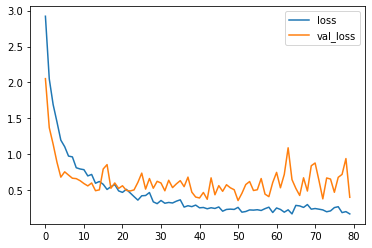

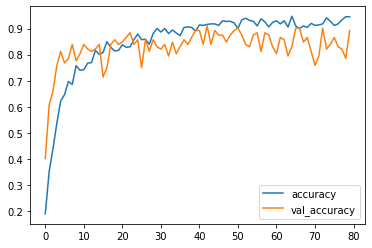

In [15]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()

In [16]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [17]:
model.save_weights("./MyDrive/flowers_classification")